In [ ]:
# !cd metrics-customerN

In [2]:
!which python
!pip install -r evalRS-KDD-2023/requirements.txt

In [9]:
import os
import sys
sys.path.insert(0, 'evalRS-KDD-2023/evaluation')

In [13]:
from EvalRSRunner import ChallengeDataset

import gc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq

# sns.set_theme("notebook")
# Change notebook data format to be like 100.10 instead of scientific notation
pd.options.display.float_format = '{:.2f}'.format

/Users/mayanksingh/VSCodeProjects/metrics-customerN/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [14]:
dataset = ChallengeDataset(force_download=False)

LFM dataset already downloaded. Skipping download.
Loading dataset.
Generating Train/Test Split.
Generating dataset hashes.


In [57]:
train, test = dataset.get_sample_train_test()
train.shape, test.shape

((6869679, 6), (29722, 3))

In [55]:
# test is only 0.4% of the data, no need to combine with train for EDA analysis
100.00*test.shape[0]/train.shape[0] 

0.4326548591280612

In [58]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
0,50967444,3059,114114,336613,1409538054,1
1,50967444,3059,114114,336156,1409537916,1
2,50967444,3059,114114,339139,1409537712,1
4,50967444,677,3035,674449,1409532988,1
5,50967444,677,3035,639652,1409532015,1


In [59]:
# convert the timestamp in a more convenient format
train["timestamp"] = pd.to_datetime(train["timestamp"], unit="s")

In [60]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1
4,50967444,677,3035,674449,2014-09-01 00:56:28,1
5,50967444,677,3035,639652,2014-09-01 00:40:15,1


In [61]:
# A session id per customer based on a 6 hr window, if their last session was more than 6 hrs ago, then it is a new session

train['session_id'] = train.groupby(['user_id', pd.Grouper(key='timestamp', freq='6H')]).ngroup()

In [62]:
train.head()

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,session_id
0,50967444,3059,114114,336613,2014-09-01 02:20:54,1,1442994
1,50967444,3059,114114,336156,2014-09-01 02:18:36,1,1442994
2,50967444,3059,114114,339139,2014-09-01 02:15:12,1,1442994
4,50967444,677,3035,674449,2014-09-01 00:56:28,1,1442994
5,50967444,677,3035,639652,2014-09-01 00:40:15,1,1442994


In [63]:
# user count
train.groupby('user_id')['user_id'].count().describe()

count   29722.00
mean      231.13
std       108.11
min         9.00
25%       149.00
50%       237.00
75%       315.00
max       496.00
Name: user_id, dtype: float64

In [64]:
# Session per user
train.groupby('user_id')['session_id'].count().describe()

count   29722.00
mean      231.13
std       108.11
min         9.00
25%       149.00
50%       237.00
75%       315.00
max       496.00
Name: session_id, dtype: float64

In [76]:
train[train['user_id']==384].sort_values(by='timestamp')

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,session_id
37926426,384,4166,184583,562698,2013-12-29 23:42:55,1,0
37926425,384,289,8126,198978,2013-12-29 23:50:28,1,0
37926424,384,7990,39548,177872,2013-12-30 00:12:10,2,1
37926423,384,245,292362,6415,2013-12-30 00:18:47,1,1
37926421,384,6290,94625,277550,2013-12-30 00:27:02,1,1
...,...,...,...,...,...,...,...
37926123,384,67,3178231,4474,2014-04-15 00:09:46,1,45
37926122,384,67,3178231,4473,2014-04-15 00:13:38,1,45
37926121,384,67,3178231,4472,2014-04-15 00:16:47,1,45
37926120,384,1513716,7625712,14892045,2014-04-16 11:33:18,16,46


In [90]:
# # Calculate track_playtime as time difference between two consecutive timestamp after sorting by user_id and timestamp and within the same session_id. The track_playtime should be for the last track played in the session.
# # So the last track won't have a track playtime
# train['playtime_mins'] = -train.sort_values(['user_id', 'timestamp']).groupby('user_id')['timestamp'].diff().dt.total_seconds()/60.00


# Cannot calculate time spent on each track because there is only one unique row per user_id, track_id. The timestamp is probably when they first heard the track

In [91]:
train[train['user_id'] == 384].sort_values(['user_id', 'timestamp'])

,user_id,artist_id,album_id,track_id,timestamp,user_track_count,session_id,track_playtime,playtime_mins
37926426,384,4166,184583,562698,2013-12-29 23:42:55,1,0,NaN,NaN
37926425,384,289,8126,198978,2013-12-29 23:50:28,1,0,7.55,-7.55
37926424,384,7990,39548,177872,2013-12-30 00:12:10,2,1,21.70,-21.70
37926423,384,245,292362,6415,2013-12-30 00:18:47,1,1,6.62,-6.62
37926421,384,6290,94625,277550,2013-12-30 00:27:02,1,1,8.25,-8.25
...,...,...,...,...,...,...,...,...,...
37926123,384,67,3178231,4474,2014-04-15 00:09:46,1,45,5.98,-5.98
37926122,384,67,3178231,4473,2014-04-15 00:13:38,1,45,3.87,-3.87
37926121,384,67,3178231,4472,2014-04-15 00:16:47,1,45,3.15,-3.15
37926120,384,1513716,7625712,14892045,2014-04-16 11:33:18,16,46,2116.52,-2116.52


In [67]:
user_session_df = train.groupby(['user_id', 'session_id'])['track_id'].count().reset_index()

In [69]:
user_session_df.columns = ['user_id', 'session_id', 'tracks_listened']

In [70]:
user_session_df.head()

,user_id,session_id,tracks_listened
0,384,0,2
1,384,1,6
2,384,2,3
3,384,3,7
4,384,4,7


In [74]:
user_session_df[user_session_df['user_id']==384].shape

(47, 3)

In [177]:
# Session and tracks_listened count
# user_summary = user_session_df.groupby(['user_id']).agg({'session_id':'nunique', 'tracks_listened': 'median'})
# user_summary.columns = ['session_count', 'customern_tracks']
# user_summary['customern_tracks'] = user_summary['customern_tracks'].astype(int)
# user_summary = user_summary.reset_index()



user_summary = user_session_df.groupby('user_id').agg({'tracks_listened': [np.median, np.std, np.mean], 'session_id': 'nunique'})
user_summary.columns = user_summary.columns.droplevel()
user_summary = user_summary.reset_index()
user_summary.columns = ['user_id', 'customern_tracks', 'impr_std', 'impr_mean', 'session_count']
user_summary['customern_tracks'] = user_summary['customern_tracks'].apply(int)
user_summary['impr_std_round'] = user_summary['impr_std'].fillna(0).apply(np.round).apply(int)

user_summary = user_summary[user_summary['session_count'] >= 3] # 99.5% of the users have >= 3 sessions


user_summary['cv'] = np.round(user_summary['impr_std']/user_summary['impr_mean'], 2)


In [178]:
user_summary

,user_id,customern_tracks,impr_std,impr_mean,session_count,impr_std_round,cv
0,384,3,3.08,4.30,47,3,0.72
1,10879,6,7.11,7.52,29,7,0.95
2,12619,2,5.54,4.84,38,6,1.14
3,14308,3,5.42,5.00,39,5,1.08
4,15067,8,7.92,8.81,31,8,0.90
...,...,...,...,...,...,...,...
29716,50081937,6,9.00,9.25,4,9,0.97
29718,50085736,1,1.20,2.00,15,1,0.60
29719,50086315,3,19.08,13.00,3,19,1.47
29720,50900118,1,1.49,1.81,89,1,0.82


In [179]:
user_summary['session_count'].describe()

count   29669.00
mean       48.63
std        28.95
min         3.00
25%        28.00
50%        43.00
75%        63.00
max       309.00
Name: session_count, dtype: float64

<AxesSubplot: ylabel='Frequency'>

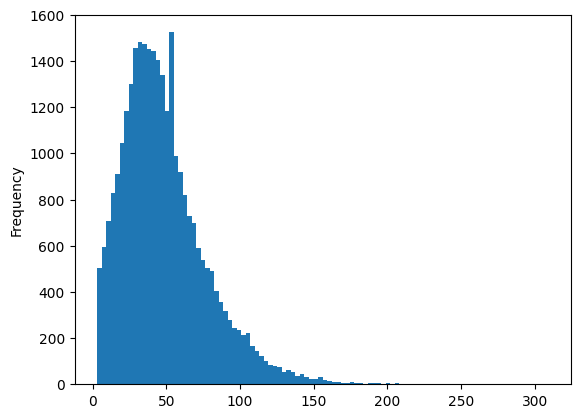

In [180]:
# Distribution of user sessions
user_summary['session_count'].plot(kind='hist', bins=100)

In [181]:
user_summary['customern_tracks'].describe()

count   29669.00
mean        3.58
std         2.55
min         1.00
25%         2.00
50%         3.00
75%         4.00
max        44.00
Name: customern_tracks, dtype: float64

<AxesSubplot: ylabel='Frequency'>

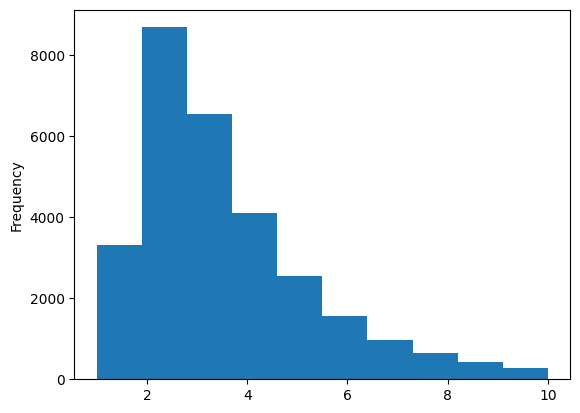

In [182]:
# Distribution of customern_tracks (median tracks listened by a customer)

# Distribution of user sessions

threshold = 10

# Create a pareto chart with less than threshold value of customern_tracks
user_summary[user_summary['customern_tracks'] <= threshold]['customern_tracks'].plot(kind='hist', bins=threshold)

In [183]:
user_summary

,user_id,customern_tracks,impr_std,impr_mean,session_count,impr_std_round,cv
0,384,3,3.08,4.30,47,3,0.72
1,10879,6,7.11,7.52,29,7,0.95
2,12619,2,5.54,4.84,38,6,1.14
3,14308,3,5.42,5.00,39,5,1.08
4,15067,8,7.92,8.81,31,8,0.90
...,...,...,...,...,...,...,...
29716,50081937,6,9.00,9.25,4,9,0.97
29718,50085736,1,1.20,2.00,15,1,0.60
29719,50086315,3,19.08,13.00,3,19,1.47
29720,50900118,1,1.49,1.81,89,1,0.82


In [184]:
# Summarising by CustomerN
customern_df = user_summary.groupby('customern_tracks')['user_id'].count().reset_index()

# Cumulative percentage of users
customern_df['cum_perc_users'] = 100.00*customern_df['user_id'].cumsum()/customern_df['user_id'].sum()

In [185]:
customern_df.head()

,customern_tracks,user_id,cum_perc_users
0,1,3321,11.19
1,2,8677,40.44
2,3,6529,62.45
3,4,4094,76.24
4,5,2535,84.79


<Figure size 1800x900 with 0 Axes>

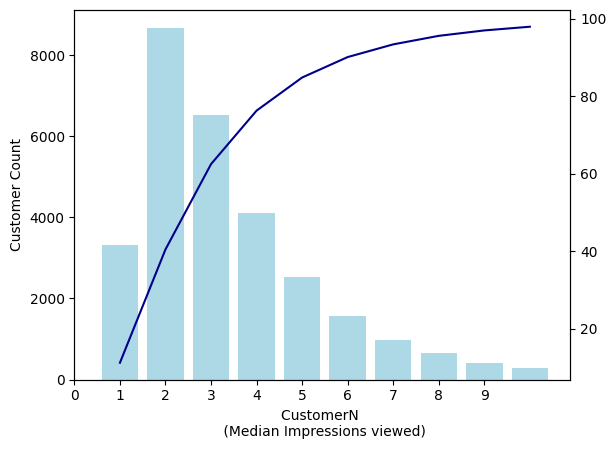

In [186]:
threshold = 10
plt.figure(figsize=(18, 9))
plot_df = customern_df[customern_df['customern_tracks'] <= threshold]
# bar plot
fig, ax = plt.subplots()
ax.bar(plot_df['customern_tracks'], plot_df['user_id'], color='lightblue')

# cum perc line
ax2 = ax.twinx()
ax2.plot(plot_df['customern_tracks'], plot_df['cum_perc_users'], color='darkblue')
plt.xticks(np.arange(0, 10, 1))
ax.set_xlabel('CustomerN \n (Median Impressions viewed)')
ax.set_ylabel('Customer Count')
plt.show()

In [187]:
user_summary.head()

,user_id,customern_tracks,impr_std,impr_mean,session_count,impr_std_round,cv
0,384,3,3.08,4.30,47,3,0.72
1,10879,6,7.11,7.52,29,7,0.95
2,12619,2,5.54,4.84,38,6,1.14
3,14308,3,5.42,5.00,39,5,1.08
4,15067,8,7.92,8.81,31,8,0.90


<AxesSubplot: xlabel='customern_tracks', ylabel='impr_std_round'>

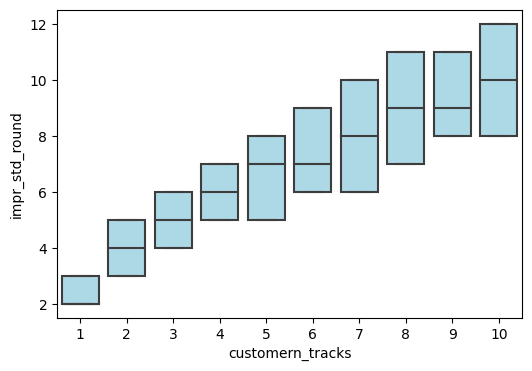

In [193]:
threshold = 10
plot_df = user_summary[user_summary['customern_tracks'] <= threshold]
plt.figure(figsize=(6,4))
sns.boxplot(x='customern_tracks',
            y='impr_std_round',
            data=plot_df,
            boxprops={'facecolor':'lightblue'},
            showfliers=False,
            whis=0)

<AxesSubplot: xlabel='customern_tracks', ylabel='cv'>

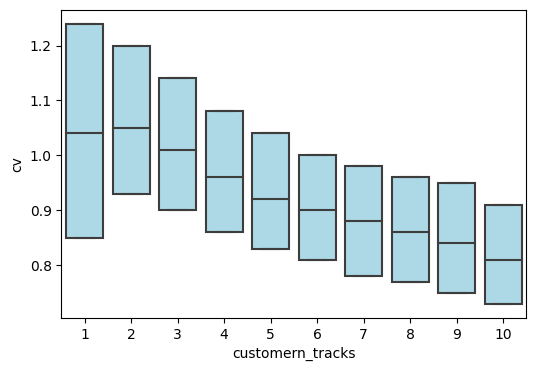

In [194]:
threshold = 10
plot_df = user_summary[user_summary['customern_tracks'] <= threshold]
plt.figure(figsize=(6,4))
sns.boxplot(x='customern_tracks',
            y='cv',
            data=plot_df,
            boxprops={'facecolor':'lightblue'},
            showfliers=False,
            whis=0)